In [1]:
import matplotlib.pyplot as plt
from src.invert_c_theta import Invert
import pandas as pd
import firedrake
import numpy as np

2024-09-16 17:30:15.420047: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 17:30:15.420495: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 17:30:15.424037: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 17:30:15.458220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 17:30:16.059127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
# drichlet_ids = [1,2,5,6,7,8,9,10,11] #dotson-crosson.geojson
# drichlet_ids = [1,2,3,4,5,6,7,9,10,11,12,13,14,15] #dotson-crosson-v1.geojson
drichlet_ids = [1,2,5,6,7,8,9,10,11]
side_ids = []
invert_dotson = Invert(outline = 'data/geojson/dotson-crosson.geojson', mesh_name = 'dotson', reg_constant_simultaneous = 1, read_mesh = False,opts = None, drichlet_ids = drichlet_ids , lcar = 9e3)

Reading local outline
Creating mesh
Reading mesh
Reading bedmachine data
Initializing function spaces
Initializing fields
Defining friction law
Setting ramp power to :  1


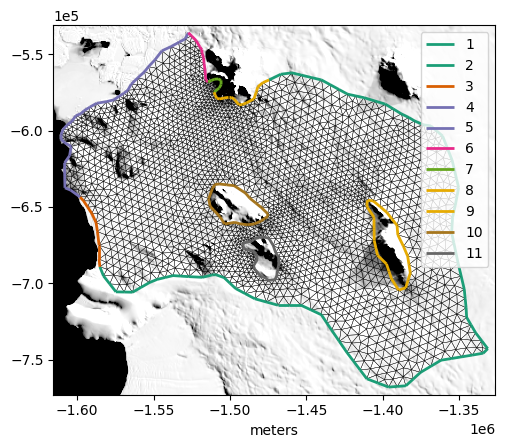

In [3]:
invert_dotson.plot_mesh()

In [4]:
invert_dotson.import_velocity_data(constant_val=0.01)
invert_dotson.import_geophysics_data(name_list=['data/geophysics/ADMAP_MagneticAnomaly_5km.tif', 
                                                'data/geophysics/ANTGG_BouguerAnomaly_10km.tif', 
                                                'data/geophysics/GeothermalHeatFlux_5km.tif',
                                                'data/geophysics/ALBMAP_SurfaceAirTemperature_5km.tif',
                                                'data/geophysics/EIGEN-6C4_GravityDisturbance_10km.tif',
                                                'data/geophysics/ALBMAP_SnowAccumulation_Arthern_5km.tif',])

Reading velocity from measures database
C0 is constant: 0.01


In [5]:
u =  invert_dotson.simulation()
firedrake.assemble(invert_dotson.loss_functional_nosigma(u))
# C = 0.01: 122180701.963183

121270889.43056971

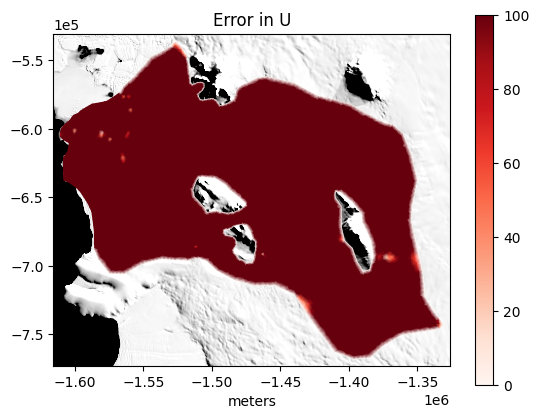

In [6]:
invert_dotson.plot_u_error_no_sigma(u, vmax = 100)

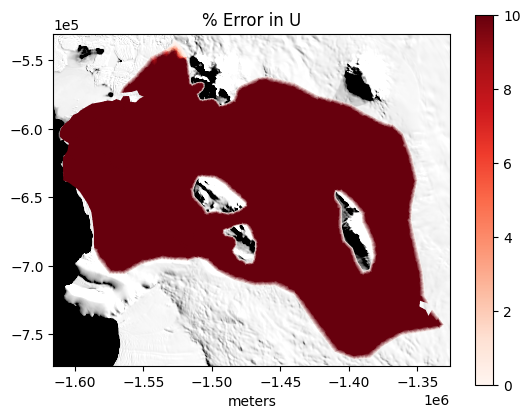

In [7]:
invert_dotson.plot_u_error_percentage(u, vmax = 10)

In [8]:
invert_dotson.default_u = u

invert_dotson.plot_u_error_percentage(u_optimized, vmax = 10)

In [9]:
df = invert_dotson.get_dataframe(u)
df.to_csv('dotson_baseline_geo_12_2_1.csv')

In [10]:
invert_dotson.invert_C_theta_simultaneously(max_iterations=300, regularization_grad_fcn= True, loss_fcn_type = 'nosigma')

Using loss function without sigma

Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     1.212709e+08   6.286605e+03                  2.025274e+04   
  1     4.245683e+07   2.185766e+03   2.025274e+04   5.063186e+04   3         2         0         1         3         
  2     7.537494e+06   3.973020e+02   5.063186e+04   5.063186e+04   4         3         0         2         2         
  3     1.338595e+06   5.088845e+01   5.063186e+04   5.063186e+04   5         4         0         3         2         
  4     3.167263e+05   1.325799e+01   5.063186e+04   5.063186e+04   6         5         0         3         2         
  5     7.451843e+04   4.169291e+00   5.063186e+04   1.265796e+05   7         6         0         3         3         
  6     7.451843e+04   4.169291e+00   1.265796e+05   7.911228e+03   8         6         2         3         2         
  7     5.064566e+04   2.24615

In [11]:
u_optimized =  invert_dotson.simulation()

In [12]:
firedrake.assemble(invert_dotson.loss_functional_nosigma(u_optimized))


217.47879795753414

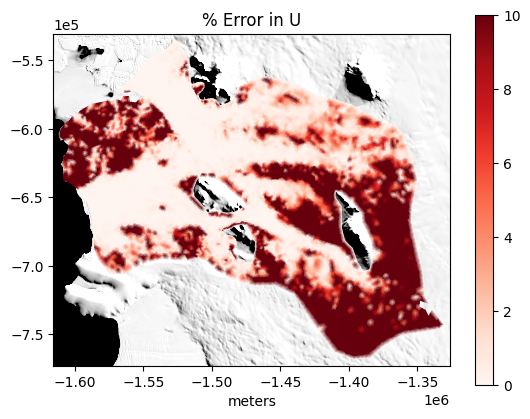

In [13]:
invert_dotson.plot_u_error_percentage(u_optimized, vmax = 10)
#0.005 : 188160.67393490166

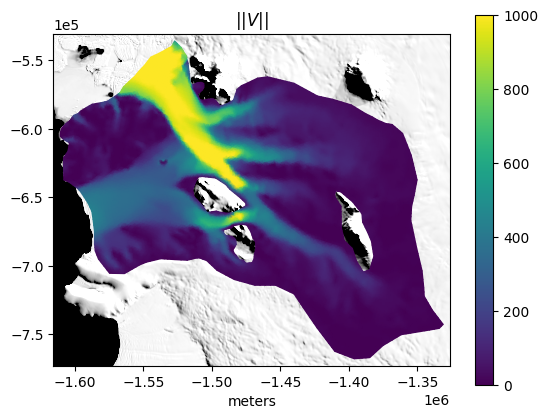

In [14]:
invert_dotson.plot_u_mag(u_optimized, vmax=1000)

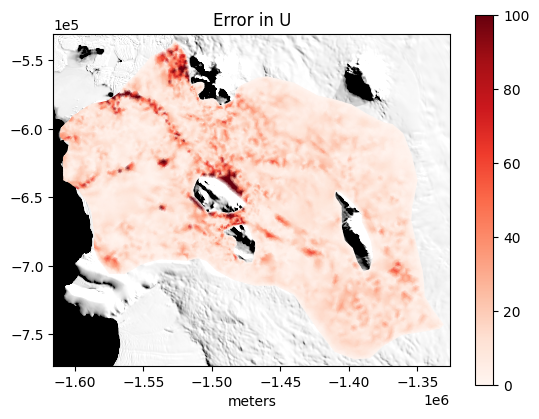

In [15]:
invert_dotson.plot_u_error_no_sigma(u_optimized, vmax = 100)

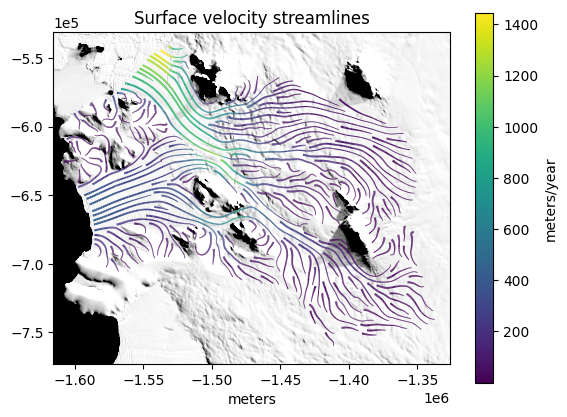

In [16]:
invert_dotson.plot_streamline_u(u_optimized)

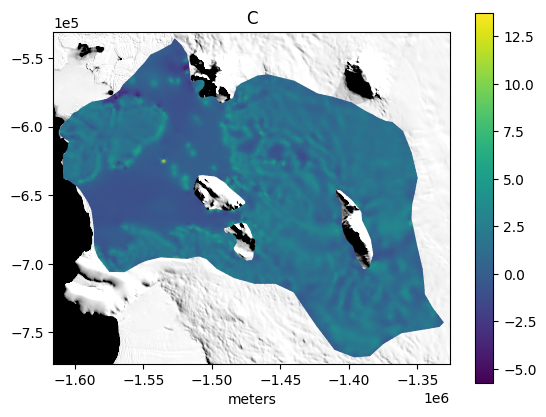

In [17]:
invert_dotson.plot_C()

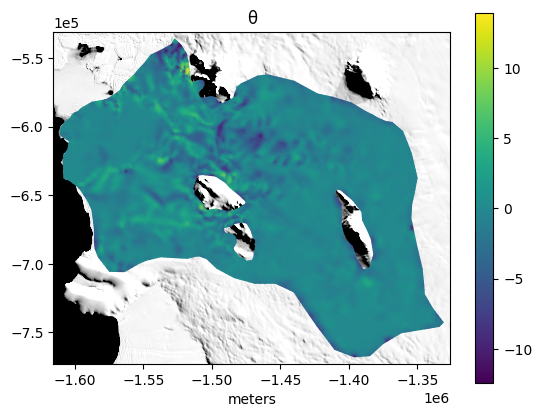

In [18]:
invert_dotson.plot_theta()

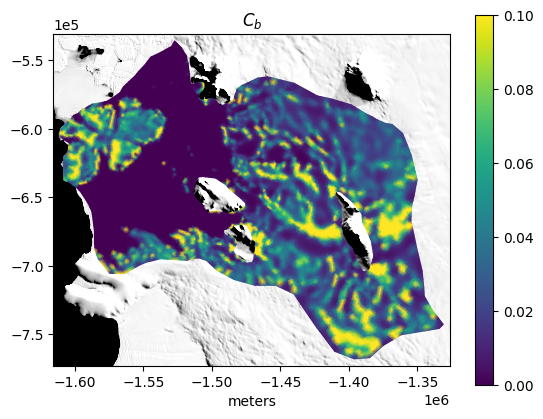

In [19]:
invert_dotson.plot_C_total(vmax = 0.1)

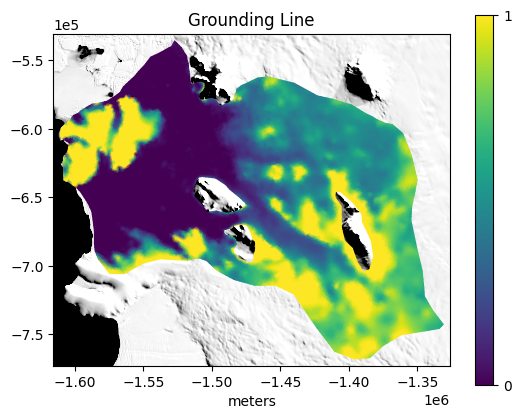

In [20]:
invert_dotson.plot_grounding_line()

In [21]:
#invert_dotson.inverse_u = invert_dotson.u_initial
invert_dotson.inverse_u = u_optimized

In [22]:
theta = invert_dotson.θ
C = invert_dotson.C

In [23]:
df = invert_dotson.get_dataframe(u_optimized)
df.to_csv('regularized_const_01C_simultaneous_dotson_r1_geo_12_2_1.csv')

In [24]:
mean_value_C = 1.0399764933270377
invert_dotson.C.dat.data[:] = np.ones(invert_dotson.C.dat.data[:].shape) * mean_value_C
u_avg=  invert_dotson.simulation()
print(firedrake.assemble(invert_dotson.loss_functional_nosigma(u_avg)))
invert_dotson.default_u = u_avg

1573735.3268189123


In [26]:
import os
import copy
import pickle


base_folder = 'mlp_ensemble'
summary_list = []
class_list = []
u_optimized_list = []
loss_function_list = []

error_list = []
columns_list = []
df_summary_list = []

# Collect all temp objects for later plotting
temp_objects = []

for folder in os.listdir(base_folder):
    if not os.path.isdir(os.path.join(base_folder, folder)):
        continue  # Skip if not a directory
    
    try:
        # Skip folders that don't contain numeric names (if needed)
        folder_num = int(folder)
    except ValueError:
        continue
    
    print('Processing folder:', folder)
    path = os.path.join(base_folder, folder)
    files = [f for f in os.listdir(path) if f.endswith('.pkl')]
    
    if not files:
        print(f"No .pkl files found in folder {folder}. Skipping.")
        continue
    
    temp_object = copy.copy(invert_dotson)
    columns = None
    r2_list, r2_adjusted_list, mse_list = [], [], []
    
    for file in files:
        try:
            with open(os.path.join(path, file), "rb") as f:
                model_bundle = pickle.load(f)
                r2_list.append(model_bundle['r2_test'])
                r2_adjusted_list.append(model_bundle['r2_adjusted_test'])
                mse_list.append(model_bundle['mse_test'])
                columns = model_bundle.get('input_columns', columns)
        except Exception as e:
            print(f"Error processing file {file} in folder {folder}: {e}")
            continue
    if r2_list and r2_adjusted_list and mse_list:
        r2_stats = pd.DataFrame(r2_list).describe()
        r2_adjusted_stats = pd.DataFrame(r2_adjusted_list).describe()
        mse_stats = pd.DataFrame(mse_list).describe()
        
        summary_list.append({
            'input_columns': columns,
            'r2_mean': r2_stats.loc['mean'].values[0],
            'r2_std': r2_stats.loc['std'].values[0],
            'r2_median': r2_stats.loc['50%'].values[0],
            'r2_adjusted_mean': r2_adjusted_stats.loc['mean'].values[0],
            'r2_adjusted_std': r2_adjusted_stats.loc['std'].values[0],
            'r2_adjusted_median': r2_adjusted_stats.loc['50%'].values[0],
            'mse_mean': mse_stats.loc['mean'].values[0],
            'mse_std': mse_stats.loc['std'].values[0],
            'mse_median': mse_stats.loc['50%'].values[0]
        })
    

    model_name = files[0][:-8]  # Assumes model files end with a fixed pattern (e.g., '_model.pkl')
    print(model_name)
    print(columns)
    columns_list.append(columns)
    
    # Ensure the model_name is properly constructed
    model_file_path = os.path.join(base_folder, folder, model_name)
    temp_object.compute_C_ML_regress(
        filename=model_file_path, 
        half=False, 
        flip=False, 
        use_driving_stress=False, 
        C_bounds=[-50, 55], 
        θ_bounds=[-102, 200],
        folder = '', 
        number_of_models=10
    )
    
    u_optimized = temp_object.simulation()
    # Store or process `u_optimized` as needed
    u_optimized_list.append(u_optimized)
    loss_val = firedrake.assemble(temp_object.loss_functional_nosigma(u_optimized))
    loss_function_list.append(loss_val)
    temp_object.ML_u = u_optimized
    # Collect the temp object for plotting later
    temp_objects.append(temp_object)
    

Processing folder: -1990894474384423823


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_3_dotson2_thwaites1_r1_geo_mixed
['b', 'mag_b', 'heatflux']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing folder: 7851807339864509352


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_2_dotson2_thwaites1_r1_geo_mixed
['heatflux', 'gravity_disturbance']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing folder: 8770223195018595074


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_5_dotson2_thwaites1_r1_geo_mixed
['b', 'mag_b', 'mag_anomaly', 'heatflux', 'gravity_disturbance']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing folder: 323692857400078563


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_11_dotson2_thwaites1_r1_geo_mixed
['s', 'b', 'h', 'mag_h', 'mag_s', 'mag_b', 'driving_stress', 'heatflux', 'snow_accumulation', 'surface_air_temp', 'gravity_disturbance']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing folder: -3529367073828865768


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_5_dotson2_thwaites1_r1_geo_mixed
['s', 'h', 'mag_h', 'mag_s', 'driving_stress']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Processing folder: 5679629665216629057


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_4_dotson2_thwaites1_r1_geo_mixed
['b', 'mag_b', 'mag_anomaly', 'gravity_disturbance']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing folder: 2911764915528207473


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_7_dotson2_thwaites1_r1_geo_mixed
['s', 'h', 'mag_h', 'mag_s', 'driving_stress', 'snow_accumulation', 'surface_air_temp']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing folder: 8726133933824278382


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_4_dotson2_thwaites1_r1_geo_mixed
['b', 'mag_b', 'heatflux', 'gravity_disturbance']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Processing folder: -5984097560118887712


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_3_dotson2_thwaites1_r1_geo_mixed
['driving_stress', 'snow_accumulation', 'surface_air_temp']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Processing folder: -2759113888670171650


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_12_dotson2_thwaites1_r1_geo_mixed
['s', 'b', 'h', 'mag_h', 'mag_s', 'mag_b', 'driving_stress', 'mag_anomaly', 'heatflux', 'snow_accumulation', 'surface_air_temp', 'gravity_disturbance']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing folder: -1076937237324748919


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_2_dotson2_thwaites1_r1_geo_mixed
['mag_h', 'mag_s']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing folder: 3404456760988170737


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_4_dotson2_thwaites1_r1_geo_mixed
['s', 'h', 'mag_h', 'mag_s']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing folder: 3899006326969799926


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_3_dotson2_thwaites1_r1_geo_mixed
['b', 'mag_b', 'gravity_disturbance']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing folder: -4237331092933986757


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_5_dotson2_thwaites1_r1_geo_mixed
['s', 'h', 'mag_h', 'mag_s', 'snow_accumulation']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Processing folder: 1922564376916388769


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_5_dotson2_thwaites1_r1_geo_mixed
['s', 'h', 'mag_h', 'mag_s', 'surface_air_temp']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing folder: -6699361163771539506


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


model_2_dotson2_thwaites1_r1_geo_mixed
['s', 'h']


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/firedrake/firedrake/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


['b', 'mag_b', 'heatflux']
R2 test: 0.15141888665016698
R2_adjusted test: 0.15139825546898125
MSE test: 0.00013070108169867186
Loss function value: 321823.9224655729


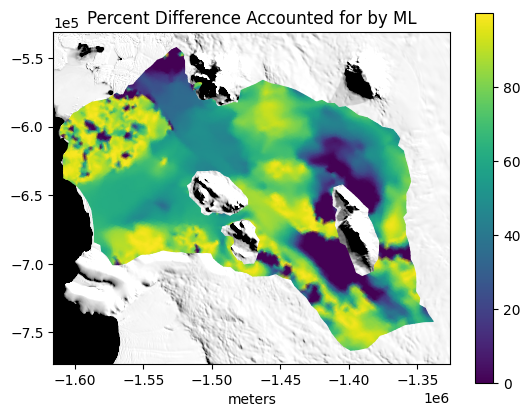

['heatflux', 'gravity_disturbance']
R2 test: -0.1301840863061469
R2_adjusted test: -0.13020240460503185
MSE test: 0.00015089182307118418
Loss function value: 19399.410587778053


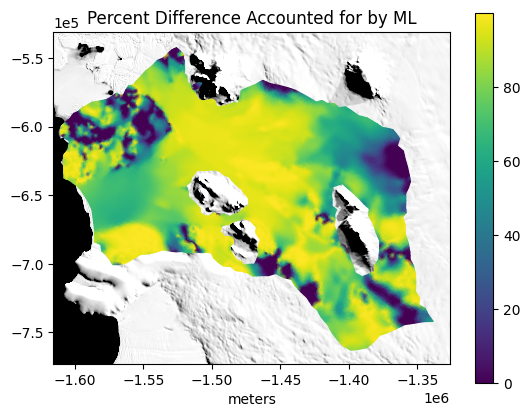

['b', 'mag_b', 'mag_anomaly', 'heatflux', 'gravity_disturbance']
R2 test: 0.5120815965417072
R2_adjusted test: 0.5120618253102778
MSE test: 7.225218579285763e-05
Loss function value: 71616.26183367094


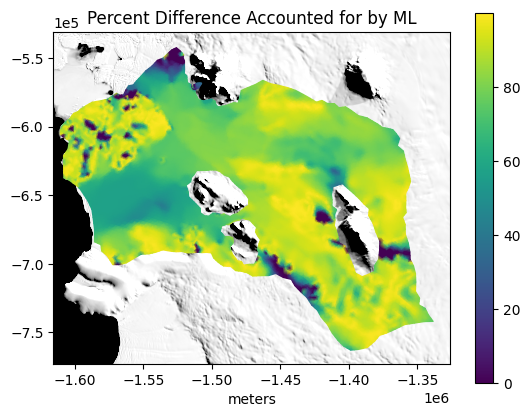

['s', 'b', 'h', 'mag_h', 'mag_s', 'mag_b', 'driving_stress', 'heatflux', 'snow_accumulation', 'surface_air_temp', 'gravity_disturbance']
R2 test: 0.8071760673926315
R2_adjusted test: 0.8071588767838971
MSE test: 4.019283729303365e-05
Loss function value: 28676.18791065536


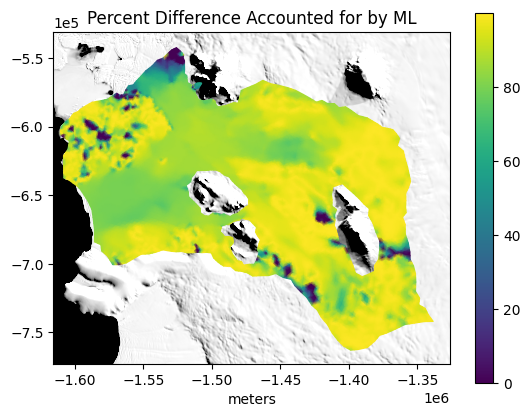

['s', 'h', 'mag_h', 'mag_s', 'driving_stress']
R2 test: 0.022165935846486982
R2_adjusted test: 0.022126312451581566
MSE test: 0.00012189780313980511
Loss function value: 116991.28078444427


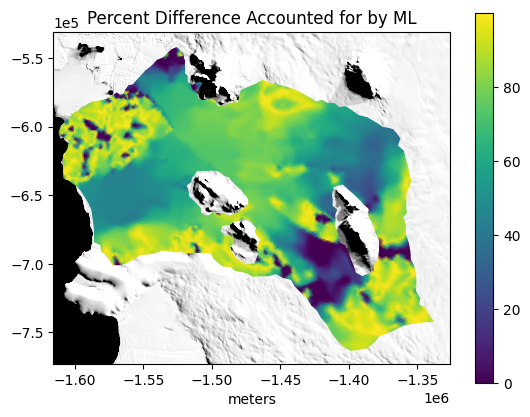

['b', 'mag_b', 'mag_anomaly', 'gravity_disturbance']
R2 test: -0.10172558509126613
R2_adjusted test: -0.10176129974327246
MSE test: 0.00013650378450149052
Loss function value: 736177.9154753883


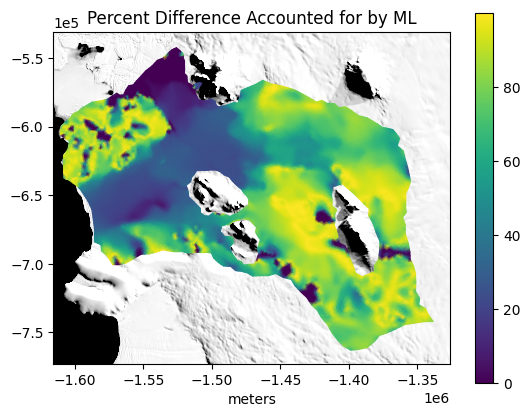

['s', 'h', 'mag_h', 'mag_s', 'driving_stress', 'snow_accumulation', 'surface_air_temp']
R2 test: 0.42408071427809035
R2_adjusted test: 0.42404804171408494
MSE test: 9.416472373557543e-05
Loss function value: 101516.5028668455


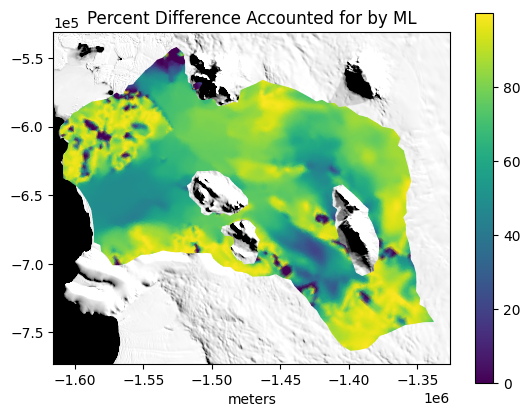

['b', 'mag_b', 'heatflux', 'gravity_disturbance']
R2 test: 0.5371337490253499
R2_adjusted test: 0.5371187442843303
MSE test: 8.136718578996773e-05
Loss function value: 54872.58094633946


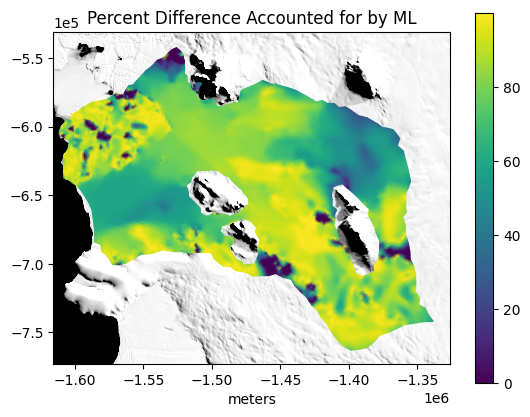

['driving_stress', 'snow_accumulation', 'surface_air_temp']
R2 test: -38.880884596753326
R2_adjusted test: -38.8818542032447
MSE test: 0.00025625363192406604
Loss function value: 1343448.7929817901


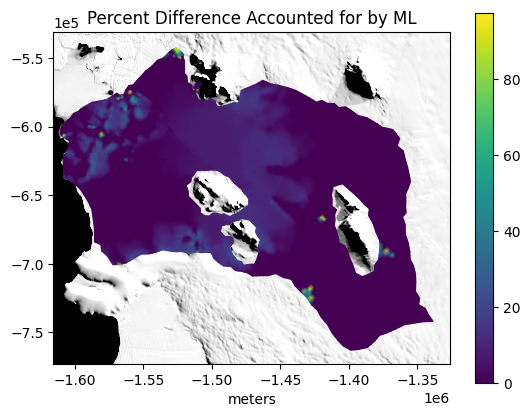

['s', 'b', 'h', 'mag_h', 'mag_s', 'mag_b', 'driving_stress', 'mag_anomaly', 'heatflux', 'snow_accumulation', 'surface_air_temp', 'gravity_disturbance']
R2 test: 0.889809317808157
R2_adjusted test: 0.8897986009551915
MSE test: 2.5396723867938764e-05
Loss function value: 19049.369612786333


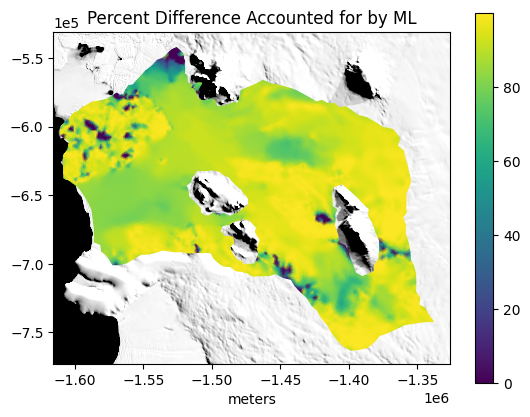

['mag_h', 'mag_s']
R2 test: -4.973258095544954
R2_adjusted test: -4.97335491156673
MSE test: 0.00023863772477964433
Loss function value: 947746.9141342763


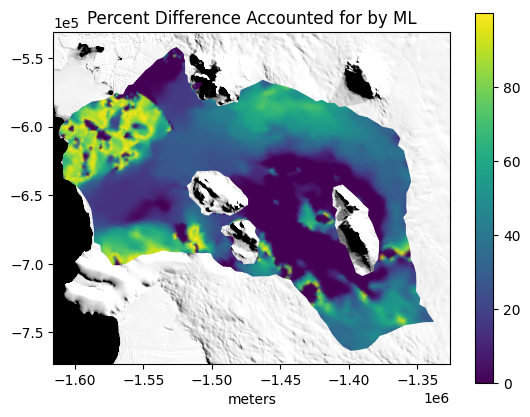

['s', 'h', 'mag_h', 'mag_s']
R2 test: 0.5341037142672549
R2_adjusted test: 0.5340886113015608
MSE test: 8.991990059537454e-05
Loss function value: 57233.37157580479


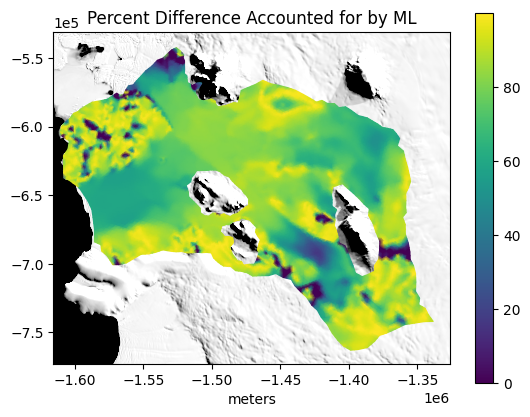

['b', 'mag_b', 'gravity_disturbance']
R2 test: -2.227666672375533
R2_adjusted test: -2.227745145222592
MSE test: 0.0002067412766328459
Loss function value: 1367684.0185793971


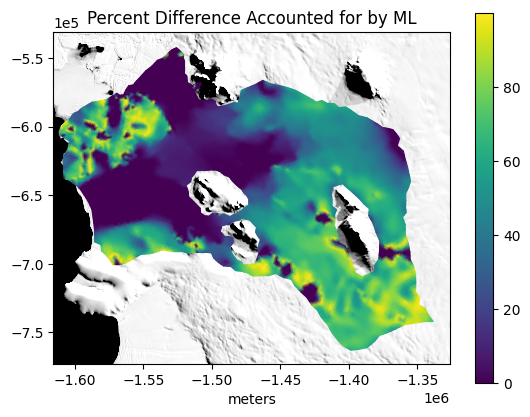

['s', 'h', 'mag_h', 'mag_s', 'snow_accumulation']
R2 test: 0.3009470717441717
R2_adjusted test: 0.30091874500525806
MSE test: 0.00011212609930310268
Loss function value: 116919.16871309189


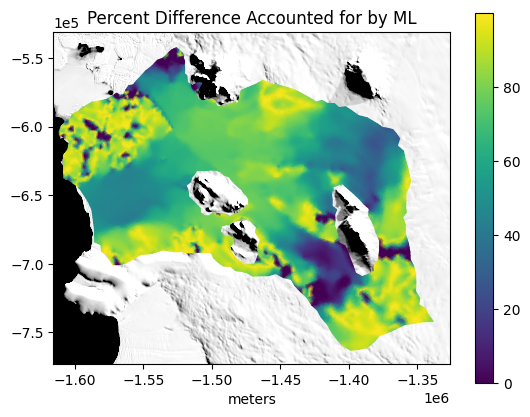

['s', 'h', 'mag_h', 'mag_s', 'surface_air_temp']
R2 test: 0.7323474850057237
R2_adjusted test: 0.7323366392991895
MSE test: 5.110743912025452e-05
Loss function value: 45540.16276962725


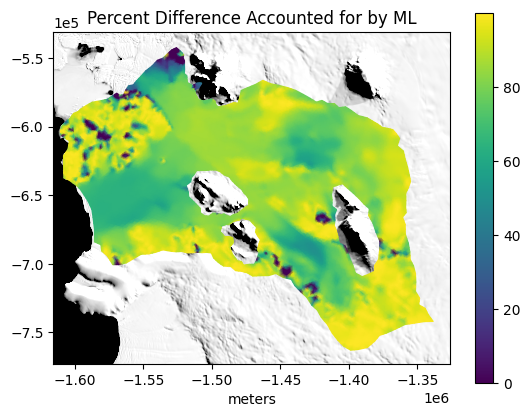

['s', 'h']
R2 test: -1.7808141794261316
R2_adjusted test: -1.7808592515395152
MSE test: 0.00021589937121152224
Loss function value: 107939.33369255971


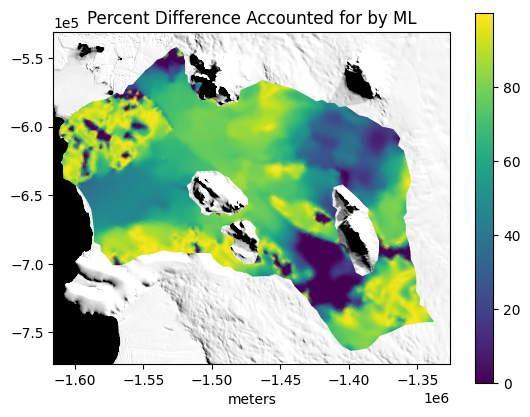

In [27]:
for i, temp_object in enumerate(temp_objects):
    
    print(columns_list[i])
    print('R2 test:', summary_list[i]['r2_mean'])
    print('R2_adjusted test:', summary_list[i]['r2_adjusted_mean'])
    print('MSE test:', summary_list[i]['mse_mean'])
    print('Loss function value:', loss_function_list[i])
    temp_object.plot_percent_accounted(vmin=0)